In [82]:
import numpy as np
import qutip as qt
from qutip import identity, sigmax, sigmay, sigmaz, tensor
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import rc
from matplotlib import cm
import matplotlib as mpl
from numpy.polynomial.hermite import hermval, hermval2d
from scipy.special import factorial
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import numpy as np
from scipy import special




In [83]:
cutoff = 50
# targ_state_qt = qt.Qobj(qt.ket2dm((qt.ket("000000")+qt.ket("111111"))/np.sqrt(2)).full())
# targ_state = tf.constant(targ_state_qt.full(), dtype = tf.float32)

In [88]:
def sqwf(delta,q=np.linspace(-10,10,2000),smax=1000):
    # Calculating square GKP0 state in position using the Matsuura(2020) Eq56.
    # delta = inverse width of Gaussian envelope
    # smax = Matsuura wavefunction sum over s
    sigma=(1/np.sqrt(2))*delta # parameter used for matsuura wavefunction
    # calculating normalisation for matsuura wavefunction:
    s=np.arange(-1000,1000)
    a=np.sum(np.exp(-np.pi*8*sigma**2*s**2))
    b=np.sum(np.exp(-np.pi*sigma**2*s**2/2))
    c=np.sum(np.exp(-np.pi*8*sigma**2*(s+(1/2))**2))
    d=np.sum(np.exp(-np.pi*sigma**2*s**2/2+1j*np.pi*s))
    N=(a*b+c*d) # this is the normalisation constant

    wf_array=np.zeros(len(q),dtype=complex) # matsuura wavefunction in position
    for i in range(len(q)):
        wf_array[i]=np.sqrt(4*np.sqrt(np.pi)/N)*(1/(2*np.sqrt(np.pi)))*np.exp(-sigma**2*q[i]**2)* \
        np.sum(np.exp(-np.pi*sigma**2*s**2+1j*np.sqrt(np.pi)*(-q[i]*np.sqrt(1-4*sigma**4))*s))
        
    return wf_array

# gkp state
q=np.linspace(-10,10,1000) # position axis
def gkp(delta,q):
    return sqwf(delta,q)

target_state=gkp(0.3, q)

def sq_GKP0(delta, cutoff, smax=1000):
    # Get the fock decomposition.
    fockcoeffs=np.zeros(cutoff,dtype=complex)
    for j in range(len(fockcoeffs)):
        y=np.exp(-q**2/2)*special.hermite(j)(q)/np.sqrt(special.factorial(j)*2**j*np.sqrt(np.pi))
        fockcoeffs[j]=np.trapz(sqwf(delta,q,smax)*np.transpose(y.conj()),q)                       
    norm=np.linalg.norm(fockcoeffs)
    sqGKP0=fockcoeffs/norm
    return sqGKP0
    
targ_state_qt_pure = qt.Qobj(sq_GKP0(0.3,cutoff))
targ_state_qt = targ_state_qt_pure*targ_state_qt_pure.dag()
targ_state = tf.constant(targ_state_qt.full(), dtype = tf.complex64)

In [89]:
def get_jump(params, basis):
    params_broadcasted = tf.broadcast_to(params[:,:, tf.newaxis], basis_tf.shape)
    return tf.reduce_sum(params_broadcasted * basis_tf, axis=0)

def calculate_output(jump, targ_state, gamma=1):
        output = gamma*(tf.matmul(tf.matmul(jump,targ_state),jump, adjoint_b=True) -
                   (1/2)*(tf.matmul(tf.matmul(jump,jump, adjoint_a=True),targ_state)
                         + tf.matmul(targ_state,tf.matmul(jump,jump, adjoint_a=True))))
        dist = tf.reduce_sum(tf.abs(output)) 
        return dist

In [98]:
schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,
                                                         decay_steps=100,
                                                         decay_rate=0.98)
Vars = tf.Variable(tf.random.uniform(minval=-1,maxval=1,shape=(cutoff, cutoff,2)))
optim_1 = tf.keras.optimizers.Adam(learning_rate=schedule)
cost_ls = []
steps=0
done=False
benchmark = 10000
cost_ls.append(benchmark)
while not done:
    with tf.GradientTape() as tape:
        tape.watch(Vars)
        jump = tf.cast(tf.complex(Vars[:,:,0], Vars[:,:,1]),dtype=tf.complex64)
        dist = (calculate_output(jump, targ_state) +
                tf.abs(tf.linalg.trace(jump)))
        cost_ls.append(dist)
    grads = tape.gradient(dist, Vars)
    optim_1.apply_gradients(zip([grads], [Vars]));
    print("Step: {}, Dist: {}".format(steps, dist), end='\r')
    steps+=1
    if dist<benchmark:
        best_jump = jump
        benchmark = dist
    if steps==1000:
        done=True
np.savetxt("Best_GKP_jump_{}_real_elems".format(cutoff), best_jump.numpy().real)
np.savetxt("Best_GKP_jump_{}_imag_elems".format(cutoff), best_jump.numpy().imag)

In [106]:
jump = best_jump
jump_qt = qt.Qobj(jump.numpy())
H = qt.Qobj(np.zeros_like(targ_state_qt.full()))
H_super = qt.superoperator.liouvillian(H,c_ops=[jump_qt])
rho_ss = qt.steadystate(H_super, method='eigen')

np.savetxt("Best_GKP_SS_{}_real_elems".format(cutoff), rho_ss.full().real)
np.savetxt("Best_GKP_SS_{}_imag_elems".format(cutoff), rho_ss.full().imag)
qt.fidelity(rho_ss, targ_state_qt)

0.9999533519590759

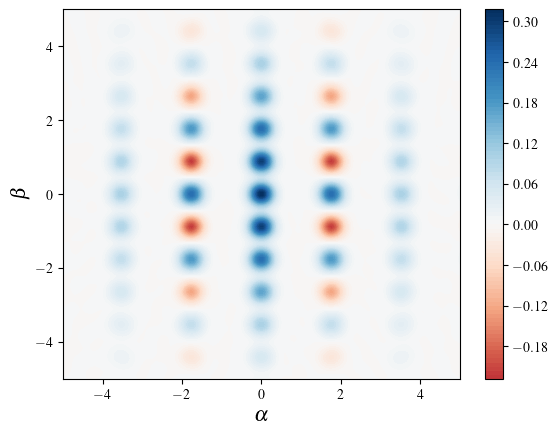

In [107]:
fig, ax = plt.subplots(1,1)
extent = np.linspace(-5,5,200)
W = qt.distributions.wigner(rho_ss, xvec=extent, yvec=extent)
# qt.visualization.plot_wigner(targ_state_qt, colorbar=True, figsize = (5,5), alpha_max=4);
wlim = abs(W).max()
cmap = cm.get_cmap("RdBu")
cf = ax.contourf(extent, extent, W, 100,
                         norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
# plt.imshow(W, cmap=cf, origin="lower")
plt.colorbar(cf, ax=ax)
# plt.title(r"$|0_L \rangle$", fontsize=20)

plt.ylabel(r"$\beta$", fontsize=15)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.savefig("BestSquareGKPWigner", dpi=600)

Text(0.5, 0, '$\\alpha$')

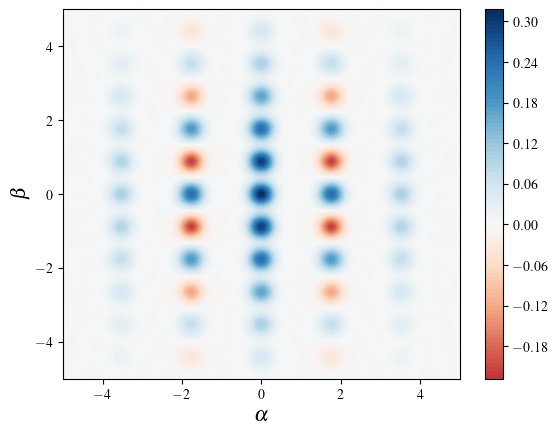

In [101]:
fig, ax = plt.subplots(1,1)
extent = np.linspace(-5,5,200)
W = qt.distributions.wigner(targ_state_qt, xvec=extent, yvec=extent)
# qt.visualization.plot_wigner(targ_state_qt, colorbar=True, figsize = (5,5), alpha_max=4);
wlim = abs(W).max()
cmap = cm.get_cmap("RdBu")
cf = ax.contourf(extent, extent, W, 100,
                         norm=mpl.colors.Normalize(-wlim, wlim), cmap=cmap)
# plt.imshow(W, cmap=cf, origin="lower")
plt.colorbar(cf, ax=ax)
# plt.title(r"$|0_L \rangle$", fontsize=20)

plt.ylabel(r"$\beta$", fontsize=15)
plt.xlabel(r"$\alpha$", fontsize=15)
# plt.savefig("ApproxSquareGKPWigner".format(cutoff), dpi=600)

In [102]:
# plt.figure(111, figsize=(20,2))
# plt.bar(np.arange(basis_size-1), best_params[:,0].numpy())
# plt.xticks(ticks = np.arange(basis_size-1), labels = label_ls[1:]);

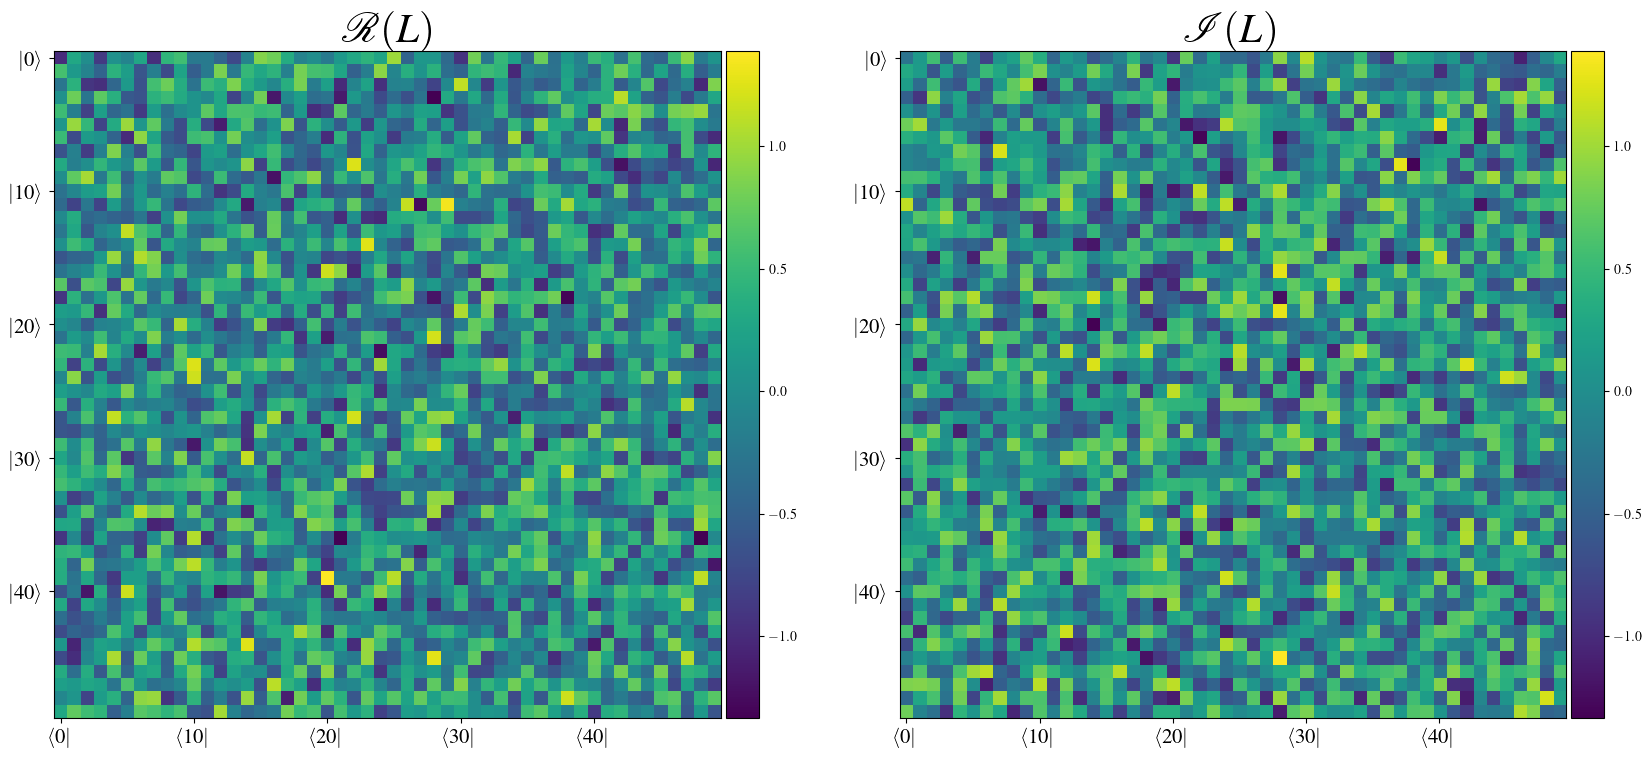

In [108]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1,2, figsize=(20,10))
im1 = axs[0].imshow(best_jump.numpy().real)
axs[0].set_title(r"$\mathcal{R}(L)$", fontsize=30)
axs[0].set_yticks(ticks = [0,10,20,30,40], 
                  labels=[r"$|0\rangle$", r"$|10\rangle$", r"$|20\rangle$", r"$|30\rangle$", r"$|40\rangle$"],
                 fontsize=15)
axs[0].set_xticks(ticks = [0,10,20,30,40], 
                  labels=[r"$\langle 0|$", r"$\langle 10|$", r"$\langle 20|$", r"$\langle 30|$", r"$\langle 40|$"],
                 fontsize=15)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
im2 = axs[1].imshow(best_jump.numpy().imag)
axs[1].set_title(r"$\mathcal{I}(L)$", fontsize=30)
axs[1].set_yticks(ticks = [0,10,20,30,40], 
                  labels=[r"$|0\rangle$", r"$|10\rangle$", r"$|20\rangle$", r"$|30\rangle$", r"$|40\rangle$"],
                 fontsize=15)
axs[1].set_xticks(ticks = [0,10,20,30,40], 
                  labels=[r"$\langle 0|$", r"$\langle 10|$", r"$\langle 20|$", r"$\langle 30|$", r"$\langle 40|$"],
                 fontsize=15)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
plt.savefig("Jump_Elems_{}".format(cutoff), dpi=600)

tf.Tensor((0.010991335+0.0067260265j), shape=(), dtype=complex64)


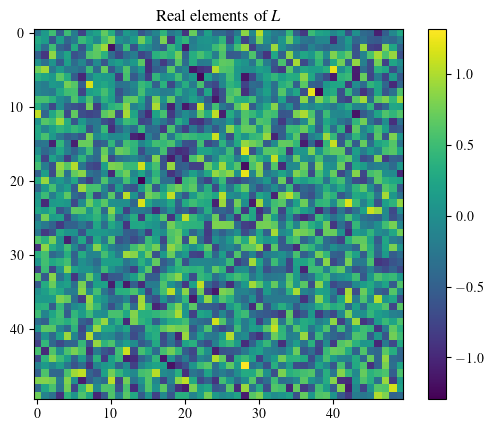

In [104]:
plt.imshow(best_jump.numpy().imag)
plt.title("Real elements of "+r"$L$")
print(tf.linalg.trace(best_jump))
plt.colorbar()

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

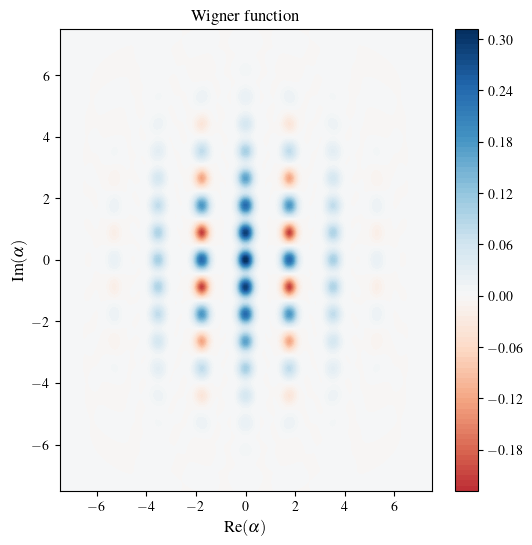

In [97]:
qt.visualization.plot_wigner(targ_state_qt_pure, colorbar=True)